# Make Hazard Curves and Maps

This notebook illustrates how to make hazard curves and hazard maps by combining results from several events.


### First set up some things needed in notebook....

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ptha_paths import data_dir, events_dir

Assuming that top level of this repository is at: /Users/rjl/ptha_tutorial
    Python codes can be found in codes_dir = /Users/rjl/ptha_tutorial/PythonCode
    Data files can be found in data_dir = /Users/rjl/ptha_tutorial/DataFiles
    Results for each event can be found in events_dir = /Users/rjl/ptha_tutorial/DataFiles/Events


In [3]:
import sys, os
from ipywidgets import interact
from IPython.display import Image, display

### Read in the topography data and define a function to make a contour plot:

In [4]:
# Read in topography data:

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0]
y=d[:,1]
B=d[:,2]
topo = reshape(B, (250,250), order='F')
X = reshape(x, (250,250), order='F')
Y = reshape(y, (250,250), order='F')

def plot_topo():
    fig = figure(figsize=(6,6))
    ax = axes()
    topo_clines = arange(0,20,2)
    contour(X,Y,topo,topo_clines,colors='k')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    return fig


### Read in image of Crescent City as background for plots

In [5]:
CCmap = imread('%s/MapsTopo/CCimage.png' % data_dir)
extent = (235.79781, 235.82087, 41.739671,41.762726)   #small region

def plot_CCmap():
    fig = figure(figsize=(6,6))
    ax = axes()
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    axis(extent)
    return fig

### Set the exceedance values

This should be a list or array of values $\zeta$ (`zeta`) representing depth of flooding on shore, or elevation above sea level offshore (in meters).  The hazard curves will be computed by determining the annual probability that the maximum $\zeta$ observed at each spatial point is above $\zeta_k$, for each value $\zeta_k$ in this list.

In [6]:
# these levels were used in original study:
#zeta = hstack((arange(0,2.,.1), arange(2.0,12.5,.5))) 

# you get nicer looking curves by using a denser set of exceedance values:
zeta = linspace(0,12,121)
nzeta = len(zeta)
print '%i exceedance values, \nzeta =  %s' % (nzeta,zeta)

121 exceedance values, 
zeta =  [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12. ]


### Set the desired annual probability for each event

Note that we are only using 14 events for this workshop.  The probabilities have been adjusted accordingly.

`event_prob` is a Python dictionary. It is initialized to an empty dictionary and then we set `event_prob[key] = value` where the keys are the names of the hypothetical events and the associated value is the annual probability.

In [7]:
all_events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']

event_prob = {}
event_prob['AASZa'] = 1./394.
event_prob['AASZb'] = 1./750.
event_prob['AASZc'] = 1./563.
event_prob['AASZd'] = 1./324.
event_prob['CSZa'] = 1./250. * .0125
event_prob['CSZb'] = 1./250. * .0125
event_prob['CSZc'] = 1./250. * .0750
event_prob['CSZd'] = 1./250. * .5000
event_prob['CSZe'] = 1./250. * .1750
event_prob['CSZf'] = 1./250. * .2250
event_prob['KmSZa'] = 1./50.
event_prob['KrSZa'] = 1./167.
event_prob['SChSZa'] = 1./300.
event_prob['TOHa'] = 1./103.

print "Annual probability of each event is set to:"
print event_prob

Annual probability of each event is set to:
{'AASZb': 0.0013333333333333333, 'AASZc': 0.0017761989342806395, 'AASZa': 0.0025380710659898475, 'SChSZa': 0.0033333333333333335, 'AASZd': 0.0030864197530864196, 'KrSZa': 0.005988023952095809, 'TOHa': 0.009708737864077669, 'KmSZa': 0.02, 'CSZa': 5e-05, 'CSZb': 5e-05, 'CSZc': 0.0003, 'CSZd': 0.002, 'CSZe': 0.0007, 'CSZf': 0.0009000000000000001}


### Define a function to combine two events

In [8]:
def combine_prob(p1,p2):
    """Returns the probability that event 1 or 2 happens"""
    return 1. - (1-p1)*(1-p2)

### Specify the set of events to include in computing hazard curves:

In [9]:
events = all_events

# Instead, to use a subset of the events, specify a list such as:
#events = ['AASZa', 'AASZb', 'AASZc']

### Compute the combined probability of exceeding each exceedance value:

`exceed_prob` is computed as an array of shape 

In [10]:
nx, ny = X.shape  # note that X is a 2d array of longitude values at each point
exceed_prob = zeros((nx,ny,nzeta))  # initialize to zero

# loop over all events and update exceed_prob at each grid point by combining
# current value with the probability Pk of this event:

for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    for k in range(nzeta):
        Pk = exceed_prob[:,:,k]  # probabilities at all points for one exceedance value zeta_k
        exceed_prob[:,:,k] = where(Hmax > zeta[k], combine_prob(event_prob[event],Pk), Pk)
        
print "Computed exceedance probabilities.  \nMaximum over all grid points is %g" % exceed_prob.max()

Computed exceedance probabilities.  
Maximum over all grid points is 0.0507195


### Plot hazard curves

The array `exceed_prob[i,j,:]` (i.e. fixing i,j and letting the last index k vary from 0 to `nzeta - 1`) gives the probability of exceedance at the `(i,j)` grid point as we vary the exceedance value `zeta[k]`.  Plotting this gives exactly the hazard curve at the `(i,j)` point.

The function `plot_hcurve` defined below plots this for a given `(longitude, latitude)` by first figuring out the index `(i,j)` for the nearest point on the grid covering Crescent City.

In [11]:
dx = X[1,0] - X[0,0]
dy = Y[0,1] - Y[0,0]
nx, ny = X.shape
xmin = X.min(); xmax = X.max()
ymin = Y.min(); ymax = Y.max()

def plot_hcurve(longitude, latitude):
    i = (longitude - X[0,0]) / dx
    j = (latitude - Y[0,0]) / dy
    if (i<0) or (i>=nx) or (j<0) or (j>=ny):
        print "out of domain"
        return 
    fig = figure(figsize=(12,5))
    subplot(1,2,1)
    p = maximum(exceed_prob[i,j,:], 1e-10)
    semilogy(zeta, p, 'b')
    ylim(1e-5,1)
    xlabel('zeta in meters')
    ylabel('annual probability')
    title('Hazard Curve')
    
    # Also plot the CC image with a red dot showing the location:
    ax = subplot(1,2,2)
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    plot([longitude], [latitude], 'ro')
    xlim(xmin,xmax)
    ylim(ymin,ymax)
    title('Location')


### Plot the hazard curve for one location:

-c:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


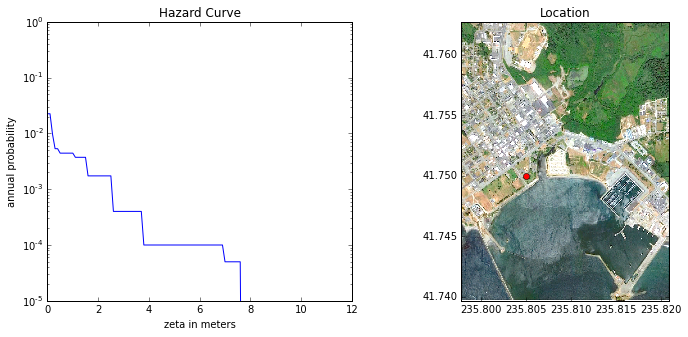

In [12]:
fig = plot_hcurve(235.805, 41.75)

### Interactive viewer to move the point around:

-c:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<function __main__.plot_hcurve>

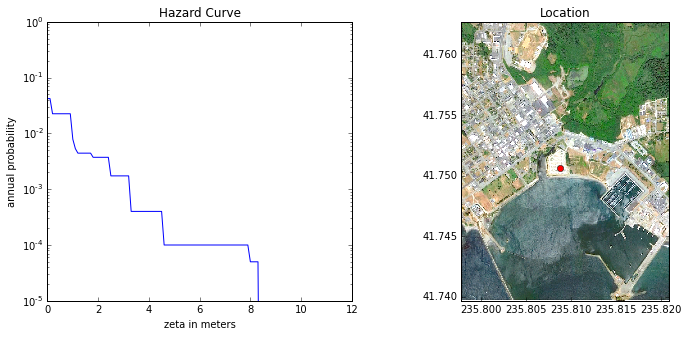

In [13]:
interact(plot_hcurve, longitude=(xmin,xmax,.001),latitude=(ymin,ymax,0.001))

## Hazard Maps

If we fix `k` then `exceed_prob[:,:,k]` is a two dimensional array giving the probability of exceedance at all points on the grid for a fixed exceedance level `zeta[k]`.  We can plot this to obtain a hazard map showing probabilities for a given exceedance value.

### Define contours and colors and a function to plot probability maps

`prob_clines` will be the probability levels to use in contour maps

`prob_colors` will define the color map to use.   This is a list of tuples (R,G,B) of red,green,blue values, chosen to go from light blue to red.

**Note:** The function `plot_pmap` defined in the cell below uses the exceedance probabilities `exceed_prob` computed above.  If you recompute these (e.g. by changing the set of events to include, or the probabilities of individual events), you must re-execute this cell to redefine `plot_pmap` before re-making the plots in later cells!

In [14]:
prob_clines = [1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 2e-2, 1e-1]
nlines = len(prob_clines)
n1 = int(floor((nlines-1)/2.))
n2 = nlines - 1 - n1

Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
Red = hstack([linspace(0,0.8,n1), ones(n2)])
Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
prob_colors = zip(Red,Green,Blue)

color_offscale = (.5,0,0)  # color to use if above maximum
prob_colors.append(color_offscale)

# Choose the background for plots by uncommenting one line:
background = plot_CCmap
#background = plot_topo

def plot_pmap(k):
    fig = background()
    contourf(X,Y,exceed_prob[:,:,k], prob_clines, colors=prob_colors,alpha = 0.6, extend='max')
    title("Annual probability of flooding above %g meters" % zeta[k])
    colorbar()
    

### Plot a sample probability map for one exceendance value:

This should plot a probability map for exceedance value zeta[13] = 1.3 m


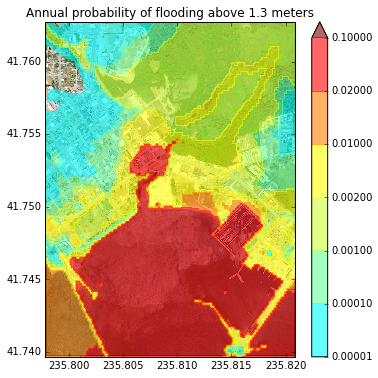

In [15]:
k = 13
print 'This should plot a probability map for exceedance value zeta[%i] = %g m' % (k,zeta[k])
fig = plot_pmap(k)

### Interactive viewer of all hazard maps:

<function __main__.plot_pmap>

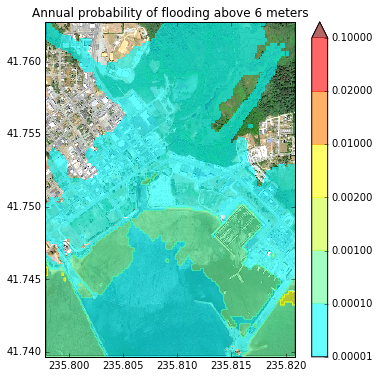

In [16]:
interact(plot_pmap, k=(0,nzeta-1,1))

### Inundation maps for given probability:

A more commonly used map is obtained by fixing a probability (e.g. $p = 0.01$ for a "100-year" flood map) and plotting the maximum depth expected with this annual probability.   

This requires determining, for each grid point `(i,j)`, the largest value of `k` for which `exceed_prob[k]`  $\geq p$. Then the value `zeta[k]` is the largest exceedance value for which the probability is at least $p$.

Recall that `zeta` is defined to be maximum depth of inundation on shore, or maximum height above MHW offshore.

**Note:** The functions `compute_zeta` and `plot_inundation_map` defined in the cell below uses the exceedance probabilities `exceed_prob` computed above.  If you recompute these (e.g. by changing the set of events to include, or the probabilities of individual events), you must re-execute this cell to redefine the functions before re-making the plots in later cells!

In [17]:
def compute_zeta(p):

    # create boolean array K with K[i,j,k] == True only where exceed_prob[i,j,k] > p:
    K = exceed_prob > p

    K[:,:,0] = True
    zeta_p = zeros(X.shape)
    for i in range(nx):
        for j in range(ny):
            zeta_p[i,j] = zeta[K[i,j,:]][-1]
    return zeta_p

# Set contour lines and colors for plotting zeta = inundation depth 

zeta_clines = [1e-3] + list(linspace(0.5,4.5,9))
nlines = len(zeta_clines)
n1 = int(floor((nlines-1)/2.))
n2 = nlines - 1 - n1
Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
Red = hstack([linspace(0,0.8,n1), ones(n2)])
Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
zeta_colors = zip(Red,Green,Blue)
color_offscale = (.5,0,0)  # color to use if above maximum
zeta_colors.append(color_offscale)


# Choose the background for plots by uncommenting one line:
background = plot_CCmap
#background = plot_topo

def plot_inundation_map(p):
    zeta_p = compute_zeta(p)
    fig =background()
    contourf(X,Y,zeta_p,zeta_clines, colors=zeta_colors, alpha = 0.6, extend='max')
    title("Depth of flooding for annual probability %g\nReturn time %5.0f years" % (p, (1./p)))
    colorbar()


### Plot a sample map:

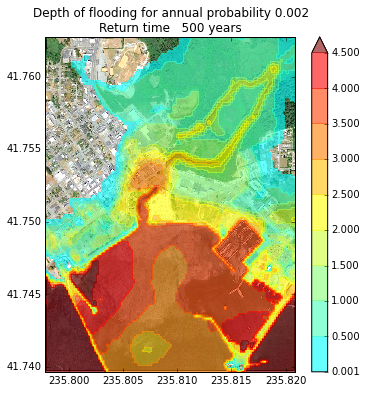

In [18]:
fig = plot_inundation_map(0.002)

### Interactive viewer for a range of probabilities:

<function __main__.plot_inundation_map>

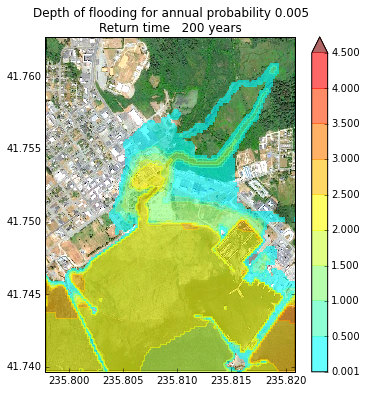

In [19]:
interact(plot_inundation_map, p=(0.00025,0.01,0.00025))

## Next steps:

The notebook [Make_Transects.ipynb](Make_Transects.ipynb) shows how to plot transects of these maps.

See [Contents.ipynb](Contents.ipynb) for other notebooks.